# Loading Graphs in NetworkX

<IPython.core.display.Javascript object>


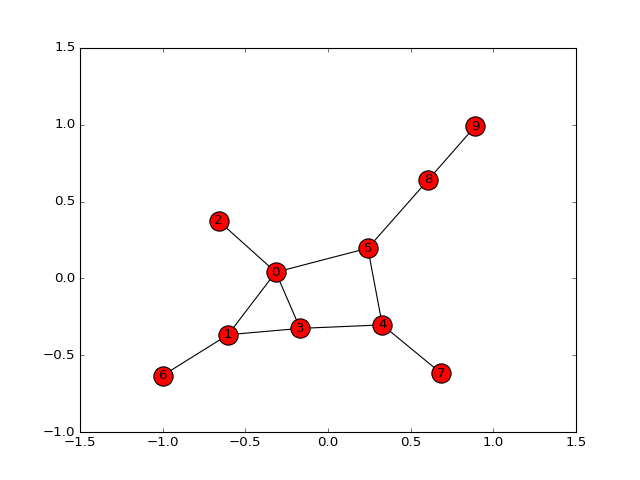

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
%matplotlib notebook

# Instantiate the graph
G1 = nx.Graph()
# add node/edge pairs
G1.add_edges_from([(0, 1),
                   (0, 2),
                   (0, 3),
                   (0, 5),
                   (1, 3),
                   (1, 6),
                   (3, 4),
                   (4, 5),
                   (4, 7),
                   (5, 8),
                   (8, 9)])

# draw the network G1
nx.draw_networkx(G1)

### Adjacency List

`G_adjlist.txt` is the adjaceny list representation of G1.

It can be read as follows:
* `0 1 2 3 5` $\rightarrow$ node `0` is adjacent to nodes `1, 2, 3, 5`
* `1 3 6` $\rightarrow$ node `1` is (also) adjacent to nodes `3, 6`
* `2` $\rightarrow$ node `2` is (also) adjacent to no new nodes
* `3 4` $\rightarrow$ node `3` is (also) adjacent to node `4` 

and so on. Note that adjacencies are only accounted for once (e.g. node `2` is adjacent to node `0`, but node `0` is not listed in node `2`'s row, because that edge has already been accounted for in node `0`'s row).

In [2]:
!cat G_adjlist.txt

cat: G_adjlist.txt: No such file or directory


If we read in the adjacency list using `nx.read_adjlist`, we can see that it matches `G1`.

In [ ]:
G2 = nx.read_adjlist('G_adjlist.txt', nodetype=int)
G2.edges()

### Adjacency Matrix

The elements in an adjacency matrix indicate whether pairs of vertices are adjacent or not in the graph. Each node has a corresponding row and column. For example, row `0`, column `1` corresponds to the edge between node `0` and node `1`.  

Reading across row `0`, there is a '`1`' in columns `1`, `2`, `3`, and `5`, which indicates that node `0` is adjacent to nodes 1, 2, 3, and 5

In [ ]:
G_mat = np.array([[0, 1, 1, 1, 0, 1, 0, 0, 0, 0],
                  [1, 0, 0, 1, 0, 0, 1, 0, 0, 0],
                  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [1, 1, 0, 0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
                  [1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
                  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
                  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])
G_mat

If we convert the adjacency matrix to a networkx graph using `nx.Graph`, we can see that it matches G1.

In [ ]:
G3 = nx.Graph(G_mat)
G3.edges()

### Edgelist

The edge list format represents edge pairings in the first two columns. Additional edge attributes can be added in subsequent columns. Looking at `G_edgelist.txt` this is the same as the original graph `G1`, but now each edge has a weight. 

For example, from the first row, we can see the edge between nodes `0` and `1`, has a weight of `4`.

In [ ]:
!cat G_edgelist.txt

Using `read_edgelist` and passing in a list of tuples with the name and type of each edge attribute will create a graph with our desired edge attributes.

In [ ]:
G4 = nx.read_edgelist('G_edgelist.txt', data=[('Weight', int)])

G4.edges(data=True)

### Pandas DataFrame

Graphs can also be created from pandas dataframes if they are in edge list format.

In [ ]:
G_df = pd.read_csv('G_edgelist.txt', delim_whitespace=True, 
                   header=None, names=['n1', 'n2', 'weight'])
G_df

In [ ]:
G5 = nx.from_pandas_dataframe(G_df, 'n1', 'n2', edge_attr='weight')
G5.edges(data=True)

### Chess Example

Now let's load in a more complex graph and perform some basic analysis on it.

We will be looking at chess_graph.txt, which is a directed graph of chess games in edge list format.

In [ ]:
!head -5 chess_graph.txt

Each node is a chess player, and each edge represents a game. The first column with an outgoing edge corresponds to the white player, the second column with an incoming edge corresponds to the black player.

The third column, the weight of the edge, corresponds to the outcome of the game. A weight of 1 indicates white won, a 0 indicates a draw, and a -1 indicates black won.

The fourth column corresponds to approximate timestamps of when the game was played.

We can read in the chess graph using `read_edgelist`, and tell it to create the graph using a `nx.MultiDiGraph`.

In [ ]:
chess = nx.read_edgelist('chess_graph.txt', data=[('outcome', int), ('timestamp', float)], 
                         create_using=nx.MultiDiGraph())

In [ ]:
chess.is_directed(), chess.is_multigraph()

In [ ]:
chess.edges(data=True)

Looking at the degree of each node, we can see how many games each person played. A dictionary is returned where each key is the player, and each value is the number of games played.

In [ ]:
games_played = chess.degree()
games_played

Using list comprehension, we can find which player played the most games.

In [ ]:
max_value = max(games_played.values())
max_key, = [i for i in games_played.keys() if games_played[i] == max_value]

print('player {}\n{} games'.format(max_key, max_value))

Let's use pandas to find out which players won the most games. First let's convert our graph to a DataFrame.

In [ ]:
df = pd.DataFrame(chess.edges(data=True), columns=['white', 'black', 'outcome'])
df.head()

Next we can use a lambda to pull out the outcome from the attributes dictionary.

In [ ]:
df['outcome'] = df['outcome'].map(lambda x: x['outcome'])
df.head()

To count the number of times a player won as white, we find the rows where the outcome was '1', group by the white player, and sum.

To count the number of times a player won as back, we find the rows where the outcome was '-1', group by the black player, sum, and multiply by -1.

The we can add these together with a fill value of 0 for those players that only played as either black or white.

In [ ]:
won_as_white = df[df['outcome']==1].groupby('white').sum()
won_as_black = -df[df['outcome']==-1].groupby('black').sum()
win_count = won_as_white.add(won_as_black, fill_value=0)
win_count.head()

Using `nlargest` we find that player 330 won the most games at 109.

In [ ]:
win_count.nlargest(5, 'outcome')